Install the client library and the pillow library

In [ ]:
!pip install --upgrade azure-cognitiveservices-vision-computervision
!pip install pillow

Import the required libraries

In [7]:
import os
import time

from azure.cognitiveservices.vision.computervision import ComputerVisionClient
from azure.cognitiveservices.vision.computervision.models import OperationStatusCodes
from msrest.authentication import CognitiveServicesCredentials
from unidecode import unidecode

Authenticate your credentials and create a client

In [26]:
subscription_key = os.environ["VISION_KEY"]
endpoint = os.environ["VISION_ENDPOINT"]
computervision_client = ComputerVisionClient(endpoint, CognitiveServicesCredentials(subscription_key))


Process the image

In [34]:
# img = open("images/test1.png", "rb")
# img = open("images/test2.jpeg", "rb")
img = open("images/test3.jpeg", "rb")
# img = open("images/test4.jpeg", "rb")
# img = open("images/test5.jpeg", "rb")
read_response = computervision_client.read_in_stream(
    img,
    mode="printed",
    raw=True
)

operation_id = read_response.headers["Operation-Location"].split("/")[-1]
while True:
    read_result = computervision_client.get_read_result(operation_id)
    if read_result.status not in ['notStarted', 'running']:
        break
    time.sleep(1)

# Print the detected text, line by line
result = []
if read_result.status == OperationStatusCodes.succeeded:
    for text_result in read_result.analyze_result.read_results:
        for line in text_result.lines:
            print(line.text)
            result.append(line.text)

print()

O propositie de
câteva curinte.
Incã una ca rã
fie mai
multa
rânduri!


Evaluate the output

In [ ]:
# get/define the ground truth
# groundTruth = ["Google Cloud", "Platform"]
# groundTruth = ["Succes in rezolvarea", "tEMELOR la", "LABORAtoarele de", "Inteligenta Artificiala!"]
groundTruth = ["O propozitie de", "cateva cuvinte.", "Inca una ca sa", "fie mai multe", "randuri!"]
# groundTruth = ["Astazi, in Cluj,", "la ora", "14:00 ploua"]
# groundTruth = ["Text scris", "de mana"]

# compute the performance
noOfCorrectLines = sum(unidecode(i) == j for i, j in zip(result, groundTruth))
print(noOfCorrectLines)

Evaluate the output using hamming distance
Hamming distance calculates the number of positions at which the corresponding symbols are different

In [31]:
def hamming_distance(v1, v2):
    """
    hamming_distance_words(v1, v2)
        This function calculates the hamming distance between two lists of strings
    :param v1: list
    :param v2: list
    :return: int
    :raises: ValueError if the lists are of unequal length
    """
    if len(v1) != len(v2):
        raise ValueError("Undefined for sequences of unequal length")
    return sum(1 for i, j in zip(v1, v2) if i != j)

# get/define the ground truth
# groundTruth = "Google Cloud\nPlatform"
# groundTruth = "Succes in rezolvarea\ntEMELOR la\nLABORAtoarele de\nInteligenta Artificiala!"
groundTruth = "O propozitie de\ncateva cuvinte.\nInca una ca sa\nfie mai multe\nranduri!"
# groundTruth = "Astazi, in Cluj,\nla ora\n14:00 ploua"
# groundTruth = "Text scris\nde mana"

# compute the performance
try:
    result_string = "\n".join(result)
    performance = hamming_distance(unidecode(result_string), groundTruth)
    print("Hamming distance characters: ", performance)
except ValueError as e:
    print(e)
    
try:
    result_string = "\n".join(result)
    result_string = unidecode(result_string).split()
    performance = hamming_distance(result_string, groundTruth.split())
    print("Hamming distance words: ", performance)
except ValueError as e:
    print(e)

Hamming distance characters:  3
Hamming distance words:  3


Evaluate the output using Levenshtein distance
Levenshtein distance calculates the number of single-character edits required to change one word into the other

In [ ]:
def levenshtein_distance(str1, str2):
    """
    levenshtein_distance(str1, str2)
        This function calculates the levenshtein distance between two strings
    :param str1: string
    :param str2: string
    :return: int
    """
    if len(str1) > len(str2):
        str1, str2 = str2, str1
    distances = range(len(str1) + 1)
    for index2, char2 in enumerate(str2):
        new_distances = [index2 + 1]
        for index1, char1 in enumerate(str1):
            if char1 == char2:
                new_distances.append(distances[index1])
            else:
                new_distances.append(1 + min((distances[index1], distances[index1 + 1], new_distances[-1])))
        distances = new_distances
    return distances[-1]

# get/define the ground truth
# groundTruth = "Google Cloud\nPlatform"
# groundTruth = "Succes in rezolvarea\ntEMELOR la\nLABORAtoarele de\nInteligenta Artificiala!"
groundTruth = "O propozitie de\ncateva cuvinte.\nInca una ca sa\nfie mai multe\nranduri!"
# groundTruth = "Astazi, in Cluj,\nla ora\n14:00 ploua"
# groundTruth = "Text scris\nde mana"

# compute the performance
result_string = "\n".join(result)
performance = levenshtein_distance(unidecode(result_string), groundTruth)
print("Levenshtein distance characters: ", performance)
result_string = unidecode(result_string).split()
performance = levenshtein_distance(result_string, groundTruth.split())
print("Levenshtein distance words: ", performance)

Evaluate the output using Jaro-Winkler distance
Jaro-Winkler distance calculates the edit distance between two strings, using the following formula:
    Sw = Sj + P * L * (1 – Sj) 
where, 
- Sj, is jaro similarity
- Sw, is jaro- winkler similarity
- P is the scaling factor (0.1 by default)
- L is the length of the matching prefix up to a maximum of 4 characters.

The Jaro similarity is given by:
    Sj = (m / s1 + m / s2 + (m - t) / m) / 3
where,
- m is the number of matching characters
- s1 is the length of the first string
- s2 is the length of the second string
- t is half the number of transpositions


In [ ]:
def jaro_distance(s1, s2) :
    """
    jaro_distance(s1, s2)
        This function calculates the jaro distance between two strings
    :param s1: string
    :param s2: string
    :return: float
    """
 
    # If the strings are equal 
    if s1 == s2:
        return 1.0

    # Length of two strings 
    len1 = len(s1)
    len2 = len(s2) 
 
    if len1 == 0 or len2 == 0:
        return 0.0 
 
    # Maximum distance upto which matching 
    # is allowed 
    max_dist = (max(len(s1), len(s2)) // 2 ) - 1 
 
    # Count of matches 
    match = 0 
 
    # Hash for matches 
    hash_s1 = [0] * len(s1) 
    hash_s2 = [0] * len(s2)  
 
    # Traverse through the first string 
    for i in range(len1) : 
 
        # Check if there is any matches 
        for j in range( max(0, i - max_dist), 
                    min(len2, i + max_dist + 1)) : 
             
            # If there is a match 
            if s1[i] == s2[j] and hash_s2[j] == 0: 
                hash_s1[i] = 1 
                hash_s2[j] = 1 
                match += 1
                break 
         
    # If there is no match 
    if match == 0:
        return 0.0 
 
    # Number of transpositions 
    t = 0 
 
    point = 0 
 
    # Count number of occurrences 
    # where two characters match but 
    # there is a third matched character 
    # in between the indices 
    for i in range(len1) : 
        if hash_s1[i]:
 
            # Find the next matched character 
            # in second string 
            while hash_s2[point] == 0:
                point += 1 
 
            if s1[i] != s2[point]:
                point += 1
                t += 1
            else :
                point += 1
                 
        t /= 2 
 
    # Return the Jaro Similarity 
    return ((match / len1 + match / len2 +
            (match - t) / match ) / 3.0)

def jaro_winkler(s1, s2) : 
    """
    jaro_Winkler(s1, s2)
        This function calculates the jaro winkler distance between two strings
    :param s1: 
    :param s2: 
    :return: 
    """
 
    jaro_dist = jaro_distance(s1, s2) 
 
    # If the jaro Similarity is above a threshold 
    if jaro_dist > 0.7:
 
        # Find the length of common prefix 
        prefix = 0 
 
        for i in range(min(len(s1), len(s2))) :
         
            # If the characters match 
            if s1[i] == s2[i]:
                prefix += 1 
 
            # Else break 
            else :
                break 
 
        # Maximum of 4 characters are allowed in prefix 
        prefix = min(4, prefix) 
 
        # Calculate jaro winkler Similarity 
        jaro_dist += 0.1 * prefix * (1 - jaro_dist) 
 
    return jaro_dist

# get/define the ground truth
# groundTruth = "Google Cloud\nPlatform"
# groundTruth = "Succes in rezolvarea\ntEMELOR la\nLABORAtoarele de\nInteligenta Artificiala!"
groundTruth = "O propozitie de\ncateva cuvinte.\nInca una ca sa\nfie mai multe\nranduri!"
# groundTruth = "Astazi, in Cluj,\nla ora\n14:00 ploua"
# groundTruth = "Text scris\nde mana"

# compute the performance
result_string = "\n".join(result)
performance = jaro_winkler(unidecode(result_string), groundTruth)
print("Jaro-Winkler similarity characters: ", performance)
result_string = unidecode(result_string).split()
performance = jaro_winkler(result_string, groundTruth.split())
print("Jaro-Winkler similarity words: ", performance)

Evaluate the output using Longest Common Subsequence
Longest Common Subsequence (LCS) is a problem to find the longest subsequence common to all sequences in a set of sequences (often just two). Note that subsequence is different from a substring, for the terms of the former need not be consecutive terms of the original sequence.

In [ ]:
def lcs(str1, str2):
    """
    lcs(str1, str2)
        This function calculates the longest common subsequence between two strings
    :param str1: string
    :param str2: string
    :return: int
    """
    # find the length of the strings
    m = len(str1)
    n = len(str2)
 
    # declaring the array for storing the dp values
    lengths = [[None] * (n + 1) for _ in range(m + 1)]
 
    """Following steps build lengths[m + 1][n + 1] in bottom up fashion
    Note that lengths[i][j] contains length of LCS of X[0..i-1]
    and Y[0..j-1]"""
    for i in range(m + 1):
        for j in range(n + 1):
            if i == 0 or j == 0:
                lengths[i][j] = 0
            elif str1[i - 1] == str2[j - 1]:
                lengths[i][j] = lengths[i - 1][j - 1] + 1
            else:
                lengths[i][j] = max(lengths[i - 1][j], lengths[i][j - 1])
 
    # lengths[m][n] contains the length of LCS of str1[0..n-1] & str2[0..m-1]
    return lengths[m][n]

# get/define the ground truth
# groundTruth = "Google Cloud\nPlatform"
# groundTruth = "Succes in rezolvarea\ntEMELOR la\nLABORAtoarele de\nInteligenta Artificiala!"
groundTruth = "O propozitie de\ncateva cuvinte.\nInca una ca sa\nfie mai multe\nranduri!"
# groundTruth = "Astazi, in Cluj,\nla ora\n14:00 ploua"
# groundTruth = "Text scris\nde mana"

# compute the performance
result_string = "\n".join(result)
performance = lcs(unidecode(result_string), groundTruth)
print("Ground truth size: ", len(groundTruth))
print("Longest Common Subsequence: ", performance)
print("LCS similarity: ", performance / len(groundTruth))

Evaluate the quality of localization of the detected text in the image using Intersection over Union (IoU)
Intersection over Union (IoU) is a measure of the overlap between two bounding boxes. It is calculated as the area of overlap between the bounding boxes divided by the area of union between the bounding boxes.

In [35]:
def intersection_over_union(box_a, box_b):
    """
    intersection_over_union(box_a, box_b)
        This function calculates the intersection over union between two bounding boxes
    :param box_a: list
    :param box_b: list
    :return: float
    """
    # determine the (x, y)-coordinates of the intersection rectangle
    x_a = max(box_a[0], box_b[0])
    y_a = max(box_a[1], box_b[1])
    x_b = min(box_a[2], box_b[2])
    y_b = min(box_a[3], box_b[3])
 
    # compute the area of intersection rectangle
    inter_area = max(0, x_b - x_a + 1) * max(0, y_b - y_a + 1)
 
    # compute the area of both the prediction and ground-truth
    # rectangles
    box_a_area = (box_a[2] - box_a[0] + 1) * (box_a[3] - box_a[1] + 1)
    box_b_area = (box_b[2] - box_b[0] + 1) * (box_b[3] - box_b[1] + 1)
 
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = inter_area / float(box_a_area + box_b_area - inter_area)
 
    # return the intersection over union value
    return iou

# get bounding box which coveres all words
bounding_boxes_words = [-1, -1, -1, -1]
if read_result.status == OperationStatusCodes.succeeded:
    for text_result in read_result.analyze_result.read_results:
        for line in text_result.lines:
            for word in line.words:
                if bounding_boxes_words[0] == -1 or word.bounding_box[0] < bounding_boxes_words[0]:
                    bounding_boxes_words[0] = word.bounding_box[0]
                if bounding_boxes_words[1] == -1 or word.bounding_box[1] < bounding_boxes_words[1]:
                    bounding_boxes_words[1] = word.bounding_box[1]
                if bounding_boxes_words[2] == -1 or word.bounding_box[4] > bounding_boxes_words[2]:
                    bounding_boxes_words[2] = word.bounding_box[4]
                if bounding_boxes_words[3] == -1 or word.bounding_box[5] > bounding_boxes_words[3]:
                    bounding_boxes_words[3] = word.bounding_box[5]
                    
# get the bounding box which coveres all lines
bounding_boxes_lines = [-1, -1, -1, -1]
if read_result.status == OperationStatusCodes.succeeded:
    for text_result in read_result.analyze_result.read_results:
        for line in text_result.lines:
            if bounding_boxes_lines[0] == -1 or line.bounding_box[0] < bounding_boxes_lines[0]:
                bounding_boxes_lines[0] = line.bounding_box[0]
            if bounding_boxes_lines[1] == -1 or line.bounding_box[1] < bounding_boxes_lines[1]:
                bounding_boxes_lines[1] = line.bounding_box[1]
            if bounding_boxes_lines[2] == -1 or line.bounding_box[4] > bounding_boxes_lines[2]:
                bounding_boxes_lines[2] = line.bounding_box[4]
            if bounding_boxes_lines[3] == -1 or line.bounding_box[5] > bounding_boxes_lines[3]:
                bounding_boxes_lines[3] = line.bounding_box[5]

# compute the performance
print("The quality of localization of the detected text is: ", intersection_over_union(bounding_boxes_lines, bounding_boxes_words))


The quality of localization of the detected text is:  0.972096286701209


Plot the image with the detected text and the bounding boxes

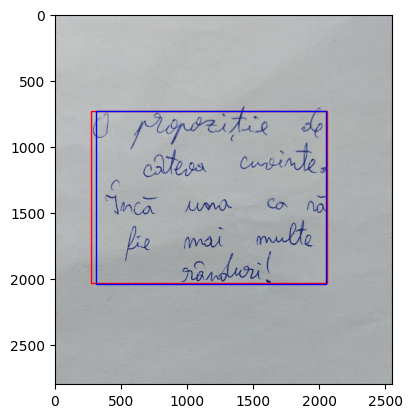

In [36]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

# Open the image file
image = Image.open("images/test3.jpeg")

# Create figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(image)

# Create a Rectangle patch
rect = patches.Rectangle((bounding_boxes_lines[0], bounding_boxes_lines[1]), bounding_boxes_lines[2] - bounding_boxes_lines[0], bounding_boxes_lines[3] - bounding_boxes_lines[1], linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

# Create a Rectangle patch
rect = patches.Rectangle((bounding_boxes_words[0], bounding_boxes_words[1]), bounding_boxes_words[2] - bounding_boxes_words[0], bounding_boxes_words[3] - bounding_boxes_words[1], linewidth=1, edgecolor='b', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

How can you improve the performance of the model?

In [20]:
from PIL import Image
# image = Image.open("images/test1.png")
# image = Image.open("images/test2.jpeg")
image = Image.open("images/test3.jpeg")
# image = Image.open("images/test4.jpeg")
# image = Image.open("images/test5.jpeg")

First thing that comes to mind is to resize the image to a smaller size, so that the model can process it faster.

In [ ]:
image = image.resize((int(image.width / 10), int(image.height / 10)))
image.save("images/test_resized.jpeg")

Another thing that comes to mind is to preprocess the image, so that the text is more visible. 

In [3]:
from PIL import ImageEnhance
enhancer = ImageEnhance.Contrast(image)
image = enhancer.enhance(2)
image.save("images/test_contrast.jpeg")

Another try was to find edges in the image, so that the text is more visible.

In [ ]:
from PIL import ImageFilter
image = image.filter(ImageFilter.FIND_EDGES)
image.save("images/test_edges.jpeg")

Then I tried to transform in negative the image, so that the text is more visible.

In [21]:
image = Image.eval(image, lambda x: 255 - x)
image.save("images/test_negative.jpeg")

I tried to combine some transformations, so that the text is more visible.

In [29]:
import cv2
# remove noise from the image
image = cv2.imread("images/test3.jpeg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
se=cv2.getStructuringElement(cv2.MORPH_RECT , (8,8))
bg=cv2.morphologyEx(image, cv2.MORPH_DILATE, se)
out_gray=cv2.divide(image, bg, scale=255)
out_binary=cv2.threshold(out_gray, 0, 255, cv2.THRESH_OTSU)[1] 
cv2.imwrite("images/test_combined.jpeg", out_gray)
image = Image.open("images/test_combined.jpeg")
# resize the image to 300x300
image = image.resize((300, 300))
# enhance the contrast
enhancer = ImageEnhance.Contrast(image)
image = enhancer.enhance(5)
image.save("images/test_combined.jpeg")

In [30]:
# img = open("images/test_resized.jpeg", "rb")
# img = open("images/test_contrast.jpeg", "rb")
# img = open("images/test_edges.jpeg", "rb")
# img = open("images/test_negative.jpeg", "rb") # this is the second best result
img = open("images/test_combined.jpeg", "rb") # this is the best result
read_response = computervision_client.read_in_stream(
    img,
    mode="printed",
    raw=True
)

operation_id = read_response.headers["Operation-Location"].split("/")[-1]
while True:
    read_result = computervision_client.get_read_result(operation_id)
    if read_result.status not in ['notStarted', 'running']:
        break
    time.sleep(1)

# Print the detected text, line by line
result = []
if read_result.status == OperationStatusCodes.succeeded:
    for text_result in read_result.analyze_result.read_results:
        for line in text_result.lines:
            print(line.text)
            result.append(line.text)

print()

O propositie de
cateva curinte.
Incã una ca ñã
fie mai multe
randuri!
